In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_builder import *
from utils import *
%matplotlib inline

from data_builder import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import argparse
import pickle
from model_builder import get_models

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
parser = argparse.ArgumentParser()
parser.add_argument("-n_test_traj", '--ntesttraj', type=int, default=1)
parser.add_argument('-dt', '--dt', type=float, default=0.01)
parser.add_argument('-tmax', '--tmax', type=float, default=10.01)
parser.add_argument('-dname', '--dname', type=str, default='forced_mass_spring')
parser.add_argument('-noise_std', '--noise', type=float, default=0)
parser.add_argument('-type','--type',type=int,default=2)
args = parser.parse_args([])
n_test_traj = args.ntesttraj
T_max = args.tmax
T_max_t = args.tmax
dt = args.dt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
type_vec = args.type
num_samples_per_traj = int(np.ceil((T_max / dt))) - 1

if args.noise != 0:
    noisy = True
else:
    noisy = False

dataset_name = args.dname

# dataset preprocessing
valid_data = get_dataset(dataset_name, n_test_traj, T_max_t, dt, noise_std=0, seed=10,type=type_vec)
BS = num_samples_per_traj

vnow, vnext, venergy, vdx, vevals = nownext(valid_data, n_test_traj, T_max_t, dt, dt)


valdat = pendpixdata(vnow, vnext, venergy, vdx, vevals)
val_dataloader = DataLoader(valdat, batch_size=BS, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = { 'valid': []}

main_pred = {'baseline':[],'HNN':[],'TDHNN':[],'TDHNN1':[],'TDHNN2':[]}


def test_model(model_name,model):
    # Each epoch has a training and validation phase
    for phase in ['valid']:
        for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict[phase]):
            q, q_next, qdx = q.float(), q_next.float(), qdx.float()
            q.to(device)
            q_next.to(device)
#                 energy_.to(device)
            qdx.to(device)
            tevals = tevals.float()
            tevals.to(device)
            loss = 0
            q.requires_grad = True
            tevals.requires_grad = True

            qinit = q[0].reshape(1, -1)

            preds = []
            for i in range(len(q_next)):
                next_step_pred = model.next_step(qinit,tevals[i])
                preds.append(next_step_pred)
                qinit = next_step_pred

            preds = torch.cat(preds).detach().numpy()
            q_next = q_next.detach().numpy()

            main_pred[model_name].append((preds,q_next))





In [18]:
# model_ft = HNN(2, 200, 1, 0.01)
model_dct = get_models(dt, type=None, hidden_dim=200)
for model_name in model_dct.keys():
    model_type = torch.load(f'forced_mass_spring_type2/{model_name}/model')
    model_type.eval()
    test_model(model_name,model_type)
    

KeyboardInterrupt: 

In [4]:
def hamiltonian_fn(coords):
    q, p = coords[:,0],coords[:,1]
    t = np.arange(0,T_max_t,dt)[1:]
    K = (p ** 2) / 2 
    U = (q ** 2) / 2  # spring hamiltonian (linear oscillator)
    return K+U-q*np.cos(3 * t)*np.cos(6*t)

In [5]:
np.arange(0,T_max_t,dt).shape

(201,)

In [6]:
avg_perf = {}
for model in model_dct.keys():
    vals = main_pred[model]
    err=0
    for i in range(len(vals)):
        pred = vals[i][0]
        true = vals[i][1]
        err += np.mean(np.square(pred-true))
    err = err/len(vals)
    print(f'{model}:{err}')
    avg_perf[model] = err

baseline:0.0018699021020438522
HNN:0.04382803626358509
TDHNN2:5.363906147977104e-05


In [7]:
avg_perf.values

<function dict.values>

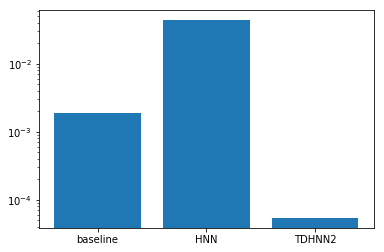

In [8]:
plt.bar(list(avg_perf.keys()),list(avg_perf.values()))
plt.yscale('log')

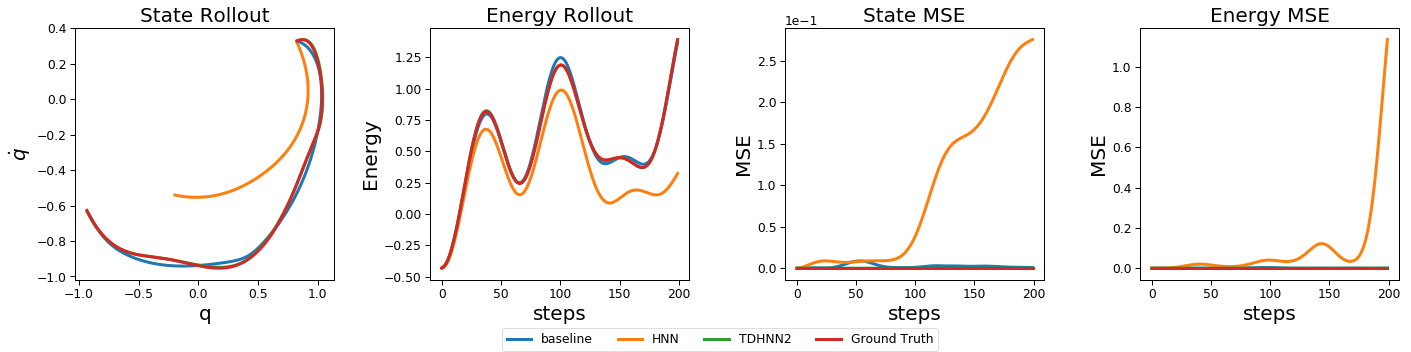

In [15]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = list(model_dct.keys())
fig,axs = plt.subplots(1,4,figsize=(5*4,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('HNN')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][-1][0]#main_pred_coll[dex]
    true_batch = main_pred[name][-1][1]
                    
    K_pred = hamiltonian_fn(yhat)
    K_true = hamiltonian_fn(true_batch)
    ham_pred = K_pred 
    ham_true = K_true 
    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[0].set_xlabel('q')
    ax[0].set_ylabel(r'$\dot{q}$')


    ax[1].set_title('Energy Rollout')
    sns.lineplot(x=range(len(ham_pred)),y=ham_pred,label=lab_list[dex],ax=ax[1],legend=False)
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('Energy')



    ax[2].set_title('State MSE')
    l1 =sns.lineplot(x=range(len(yhat)),y=((yhat-true_batch)**2).mean(1),label=lab_list[dex],ax=ax[2],legend=False)
    ax[2].set_xlabel('steps')
    ax[2].set_ylabel('MSE')

    ax[3].set_title('Energy MSE')
    l2 =sns.lineplot(x=range(len(yhat)),y=(ham_pred-ham_true)**2,label=lab_list[dex],ax=ax[3],legend=False)
    ax[3].set_xlabel('steps')
    ax[3].set_ylabel('MSE')
    
sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(ham_pred)),y=ham_true,label='Ground Truth',ax=ax[1],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[2],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[3],legend=False)
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('mass_spring_long.pdf',dpi=2400,bbox_inches='tight')


In [10]:
for name, param in model_type.named_parameters():
    if param.requires_grad:
        print (name, param.data)

W tensor([[0.2205]])
mlp1.weight tensor([[-3.7000e-02,  4.7811e-02],
        [-4.6136e-02,  5.6255e-02],
        [ 9.2738e-02, -5.9448e-02],
        [ 1.6573e-01,  1.8512e-01],
        [ 1.0490e-01,  2.9029e-02],
        [-5.3123e-02, -1.0429e-01],
        [-1.0472e-02, -3.5708e-02],
        [ 1.1880e-01,  1.2421e-01],
        [-1.0961e-02, -3.9390e-02],
        [ 4.7514e-02, -3.7938e-02],
        [-1.3763e-01,  1.4532e-01],
        [ 6.6924e-02,  9.6067e-02],
        [ 8.2569e-02,  5.1535e-02],
        [ 6.1810e-02,  1.8069e-02],
        [ 5.0233e-02,  8.9691e-02],
        [-1.3726e-03, -7.3044e-02],
        [-2.5879e-02, -1.5736e-02],
        [ 4.8090e-02,  5.6784e-02],
        [ 3.8231e-02,  1.0154e-01],
        [ 8.0625e-02,  1.0417e-01],
        [-6.3408e-02,  9.7781e-02],
        [ 5.4252e-02,  6.4936e-02],
        [ 9.0817e-04,  1.2146e-01],
        [-7.0973e-02,  1.6198e-01],
        [ 1.2184e-01,  2.4426e-01],
        [ 1.8990e-01,  9.5441e-03],
        [-8.1627e-02,  8.8577e-

In [ ]:
model_type.

In [14]:
1/(1+np.exp(-0.22))

0.5547792351072148

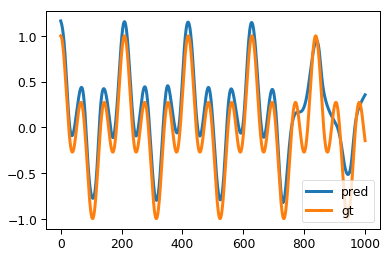

In [12]:
tevals = torch.arange(0,10.01,0.01)
tevals.to(device)
tevals.requires_grad = True
tevals = tevals.float()
f = model_type.get_F(tevals.reshape(-1,1))
plt.plot(-0.55*f.detach().numpy(),label='pred')
plt.plot(np.cos(3*tevals.detach().numpy())*np.cos(6*tevals.detach().numpy()),label='gt')
plt.legend()